In [1]:
import os
os.chdir('../') 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import anndata as ad
import pandas as pd

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0
/home/alextopalova/miniconda3/envs/archmap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(12, 3))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
condition_key = 'batch'
cell_type_key = 'final_annotation'
target_conditions = ['10X']

surgery_path = 'surgery_model'
output = 'Immune_ALL_human.h5ad'

In [5]:
adata_all = sc.read(output)

source_adata = adata_all[~adata_all.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata_all[adata_all.obs[condition_key].isin(target_conditions)].copy()

In [6]:
model = sca.models.SCVI.load(surgery_path, adata_all)

INFO     File surgery_model/model.pt already downloaded                                                            


In [7]:
adata_ref_latent = sc.AnnData(model.get_latent_representation(adata=source_adata))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [8]:
adata_ref_latent

AnnData object with n_obs × n_vars = 22779 × 10
    obs: 'cell_type', 'batch'

In [9]:
adata_query_latent = sc.AnnData(model.get_latent_representation(adata=target_adata))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [10]:
adata_query_latent.n_vars

10

In [11]:
adata_all_latent =sc.AnnData(model.get_latent_representation(adata=adata_all))
adata_all_latent.obs['cell_type'] = adata_all.obs[cell_type_key].tolist()
adata_all_latent.obs['batch'] = adata_all.obs[condition_key].tolist()

In [12]:
combined_emb = ad.concat([source_adata, adata_query_latent], index_unique=None)

### KNN Classification
Symphony approach: Calculates the weighted Mahalanobis distance for the query cells to reference clusters. Returns a vector of distance scores, one per query cell. Higher distance metric indicates less confidence - The actual per-cell score is the average of the distances weighted by the clusters the cell belongs to

Steps:
1. Calculate centroids of reference
2. Calculate the Mahalanobis distance of every cell to the centroids
3. Calculate avg of the distances weighted by the cluster the cell belongs to

In [13]:
import scanpy as sc
from sklearn.cluster import KMeans
# from scipy.spatial.distance import mahalanobis

In [14]:
num_clusters =adata_ref_latent.n_vars

In [15]:
num_clusters

10

In [16]:
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(adata_ref_latent.X)

# Get the cluster labels assigned by KMeans
cluster_labels = kmeans.labels_

In [17]:
import scipy

In [18]:
def mahal(v, data):
    vector = np.zeros(len(data))
    for centroid_index in range(len(data)):
        v_mu = v - np.mean(data[centroid_index])
        inv_cov = np.eye(len(data[centroid_index]))
        left = np.dot(v_mu, inv_cov)
        mahal = np.dot(left, v_mu.T)
        vector[centroid_index] = mahal
    return vector

In [19]:
uncertainties = pd.DataFrame(columns=["uncertainty"], index=adata_query_latent.obs_names)
centroids = kmeans.cluster_centers_

In [20]:
adata_query = kmeans.transform(adata_query_latent.X)

In [21]:
for query_cell_index in range(len(adata_query)):
    # Calculate Mahalanobis distance for each query cell
    query_cell = adata_query_latent.X[query_cell_index]
    cell_distances = []
    
    distance = mahal(query_cell, centroids) 
    weighted_distance = np.average(distance/ np.linalg.norm(distance))
    uncertainties.iloc[query_cell_index]['uncertainty'] = weighted_distance

In [22]:
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()
uncertainties

,uncertainty,batch,cell_type
0,0.314552,10X,CD4+ T cells
1,0.302572,10X,Monocyte-derived dendritic cells
2,0.308876,10X,CD14+ Monocytes
3,0.308606,10X,NK cells
4,0.315109,10X,CD20+ B cells
...,...,...,...
10722,0.304094,10X,CD4+ T cells
10723,0.312606,10X,CD14+ Monocytes
10724,0.309375,10X,NKT cells
10725,0.312123,10X,CD4+ T cells


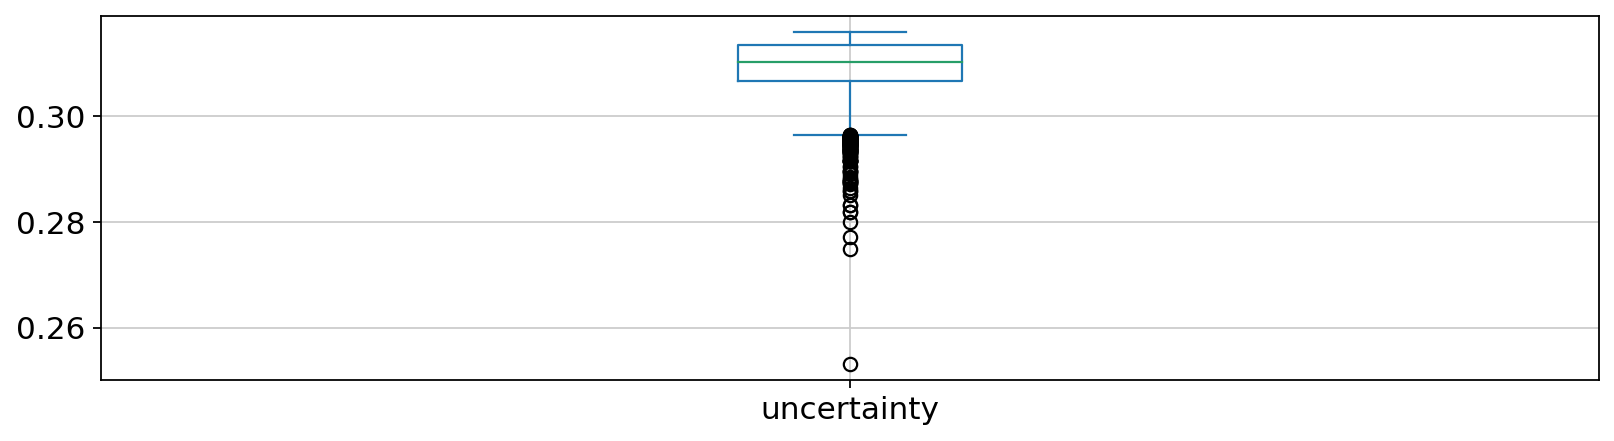

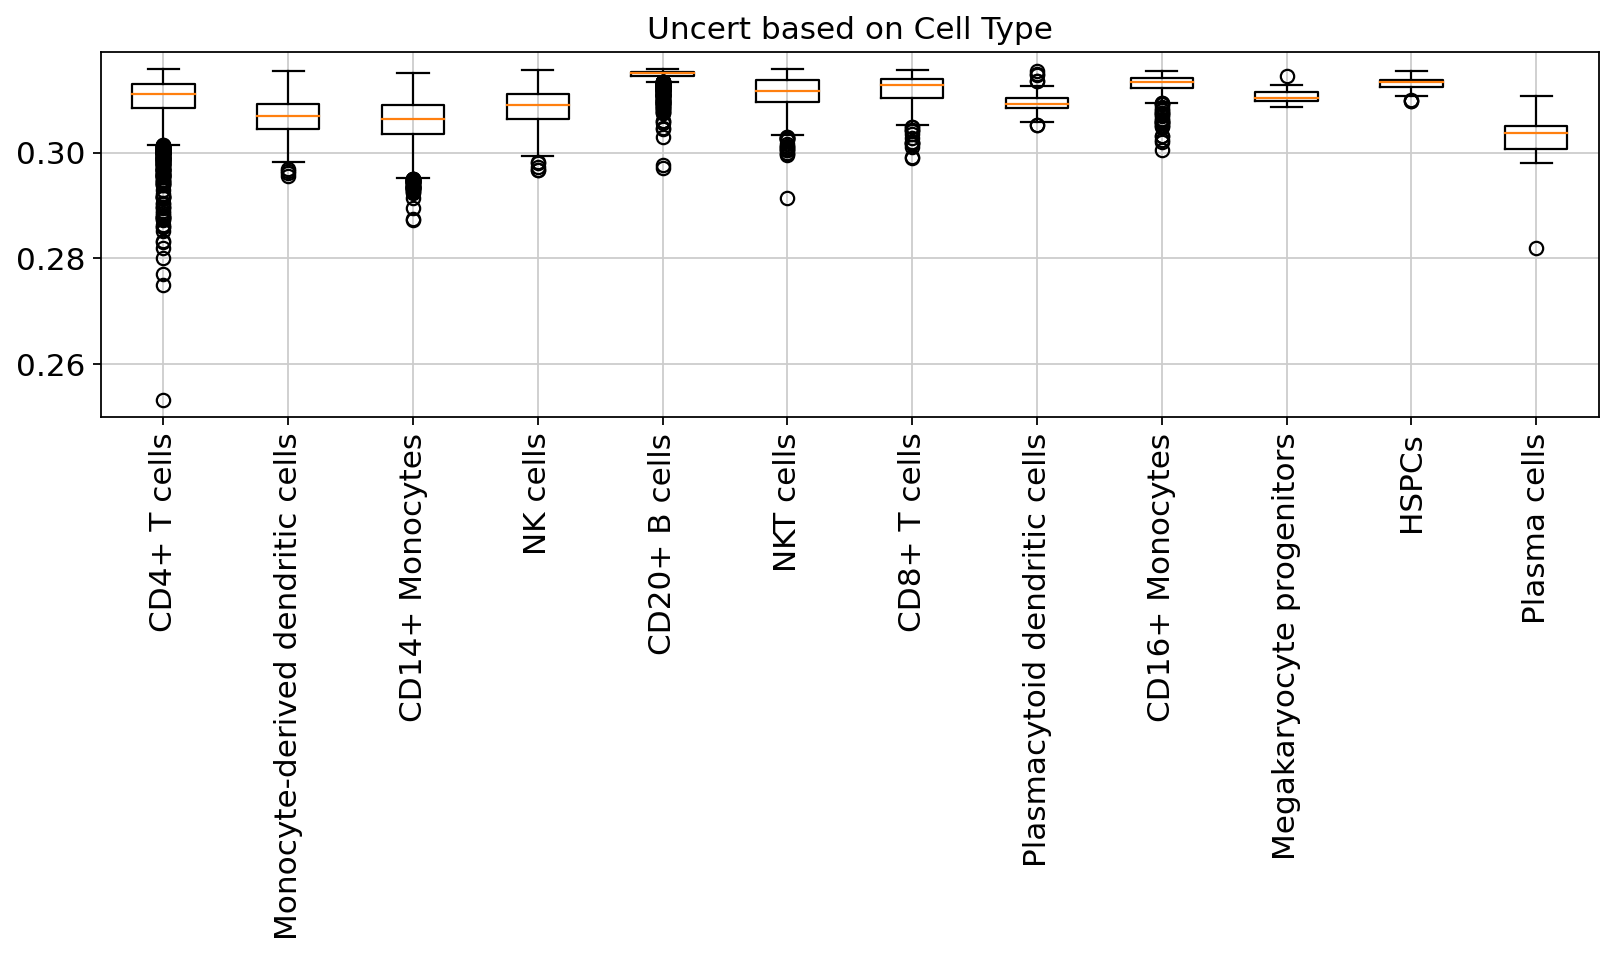

In [23]:
import matplotlib.pyplot as plt
import numpy as np

data = []
uncertainties["uncertainty"].plot(kind='box')
labels = uncertainties["cell_type"].unique()
for cell_type in labels:
  pl = uncertainties[uncertainties["cell_type"] == cell_type]["uncertainty"]
  data.append(pl)

fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Uncert based on Cell Type')
plt.show()

In [ ]:
#As a whole function
def metric(adata_ref_latent, adata_query_latent):
    num_clusters = adata_ref_latent.n_vars
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(adata_ref_latent.X)
    uncertainties = pd.DataFrame(columns=["uncertainty"], index=adata_query_latent.obs_names)
    centroids = kmeans.cluster_centers_
    adata_query = kmeans.transform(adata_query_latent.X)

    for query_cell_index in range(len(adata_query)):
        # Calculate Mahalanobis distance for each query cell
        query_cell = adata_query_latent.X[query_cell_index]
        cell_distances = []
    
        distance = mahal(query_cell, centroids) 
        weighted_distance = np.average(distance/ np.linalg.norm(distance))
        uncertainties.iloc[query_cell_index]['uncertainty'] = weighted_distance
    return uncertainties